<a href="https://colab.research.google.com/github/YasminaNasser/Stroke-Prediction-Data-Mining/blob/google-collab/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def check_duplicate_rows_with_visualization(df, correlation_threshold=0.95, remove_duplicates=False):
    """
    Check for duplicate rows, visualize the correlation matrix, and handle non-numeric data.
    Optionally remove exact duplicate rows.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        correlation_threshold (float): Threshold to flag columns as highly correlated.
        remove_duplicates (bool): Whether to remove exact duplicate rows.

    Returns:
        pd.DataFrame: The DataFrame with duplicates handled as specified.
    """
    print("------------------Visualizing Correlation Matrix------------------")

    # Handle non-numeric data by encoding or dropping
    df_numeric = df.copy()
    for col in df_numeric.select_dtypes(include=['object', 'category']).columns:
        #print(f"Encoding categorical column: {col}")
        df_numeric[col] = LabelEncoder().fit_transform(df_numeric[col])

    # Calculate and visualize the correlation matrix
    corr_matrix = df_numeric.corr()

    # Print all the features in the correlation matrix
    print("\nFeatures in the Correlation Matrix:")
    print(corr_matrix.columns.tolist())

    # Print correlation values for 'id' column if it exists
    if 'id' in corr_matrix.columns:
        print("\nCorrelation values for 'id' column:")
        print(corr_matrix['id'])

    plt.figure(figsize=(8, 5))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

    print("\nCorrelation Matrix:")
    print(corr_matrix)

    # Analyze duplicate rows based on the correlation matrix
    duplicate_rows = df[df.duplicated()]
    print("\n------------------Checking for Duplicate Rows------------------")

    if not duplicate_rows.empty:
        print(f"Number of duplicate rows: {len(duplicate_rows)}")
        print("Duplicate Rows:\n", duplicate_rows)
    else:
        print("No exact duplicate rows found.")
        print("Note: Based on the correlation matrix, there are no duplicate rows.")

    # Remove duplicates if specified
    if remove_duplicates and not duplicate_rows.empty:
        df = df.drop_duplicates()
        print("\nDuplicate rows removed.")

    return df


In [ ]:
from sklearn.preprocessing import LabelEncoder

def remove_useless_columns_using_correlation(df, threshold=0.003550, reason="The column is detected as not contributing significantly to other features."):
    """
    Remove columns that do not contribute significantly to other columns based on the correlation matrix.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        threshold (float): The correlation threshold to flag a column as useless.
        reason (str): The reason provided when a column is detected as not contributing significantly.

    Returns:
        pd.DataFrame: The DataFrame with the useless columns removed.
    """
    # Handle non-numeric data by encoding them
    df_numeric = df.copy()
    for col in df_numeric.select_dtypes(include=['object', 'category']).columns:
        df_numeric[col] = LabelEncoder().fit_transform(df_numeric[col])

    # Compute the correlation matrix
    correlation_matrix = df_numeric.corr()

    # Initialize a list to store columns to drop
    columns_to_drop = []

    # Ensure 'id' column is removed if it exists
    if 'id' in df.columns:
        columns_to_drop.append('id')
        print(f"Detected 'id' column, removing it. Reason: {reason}")

    # Iterate over each column and check its correlation with other columns
    for column in correlation_matrix.columns:
        # Get the correlations of the current column with all other columns (excluding itself)
        column_correlation = correlation_matrix[column].drop(column)

        # If all correlations are below the threshold, consider it as a useless column
        if all(abs(column_correlation) < threshold) and column not in columns_to_drop:
            columns_to_drop.append(column)
            print(f"Detected '{column}' column as not contributing significantly to other columns, removing it.")
            print(f"Reason: {reason}")

    # Drop the detected useless columns
    if columns_to_drop:
        df = df.drop(columns=columns_to_drop)
        print(f"Columns dropped: {', '.join(columns_to_drop)}")
    else:
        print("No columns detected as useless based on the correlation threshold.")

    return df


In [ ]:
def handle_numerical_missing_data_and_normalize(ds):
    # Identify numerical features (excluding the last column)
    numerical_features = ds.iloc[:, :-1].select_dtypes(include=[np.number]).columns.tolist()
    print("------------------ Extracting Numerical Features ------------------")
    print(numerical_features)

    # Create a dataframe with only numerical features (excluding the target column)
    dataframe_N = ds[numerical_features]
    print("------------------ Numerical DataFrame ------------------------")
    print(dataframe_N)

    # Handle missing data: Replace NaN values with the mean of the column
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    dataframe_N_imputed = imp_mean.fit_transform(dataframe_N)

    # Convert the NumPy array back to a DataFrame with the original column names
    dataframe_N_imputed = pd.DataFrame(dataframe_N_imputed, columns=numerical_features)

    # Normalize the data to a range of [0, 1]
    normalizer = MinMaxScaler(feature_range=(0, 1))
    dataframe_N_normalized = normalizer.fit_transform(dataframe_N_imputed)

    # Convert the normalized array back to a DataFrame with the original column names
    dataframe_N_normalized = pd.DataFrame(dataframe_N_normalized, columns=numerical_features)

    # Update the original dataset with the normalized numerical features
    ds[numerical_features] = dataframe_N_normalized

    print("------------------- Data After Handling Missing Values and Normalization ---------------")
    print(ds)
    return ds


In [ ]:
def handle_categorical_missing_data(df):
    # Extract categorical features
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    print("------------------Extracting Categorical Features------------------")
    print("Categorical Features:", categorical_features)

    total_rows = len(df)
    threshold = total_rows * 0.01  # 1%

    for feature in categorical_features:
        print(f"\nProcessing Feature: {feature}")

        # Get value counts for the feature
        value_counts = df[feature].value_counts(dropna=False)
        print(f"Value Counts:\n{value_counts}")

        # Identify frequent and infrequent values
        frequent_values = value_counts[value_counts > threshold].index
        infrequent_values = value_counts[value_counts <= threshold].index
        print(f"Frequent Values (Threshold > {threshold:.2f}): {list(frequent_values)}")
        print(f"Infrequent Values (Threshold <= {threshold:.2f}): {list(infrequent_values)}")

        # Replace infrequent values and NaNs with the most frequent value
        most_frequent_value = value_counts.idxmax()
        df[feature] = df[feature].apply(
            lambda x: x if x in frequent_values else most_frequent_value
        )

        print(f"Updated Feature Values:\n{df[feature].value_counts(dropna=False)}")
        print("-------------------------------------------------------------------")

    return df


In [ ]:
def detect_outliers(df, columns):
    outlier_indices = {}

    print("------------------Detecting Outliers------------------")
    for column in columns:
        Q1 = df[column].quantile(0.25)  # First quartile
        Q3 = df[column].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1                   # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        if not outliers.empty:
            print(f"Outliers in column '{column}':")
            print(outliers)
            outlier_indices[column] = outliers.index.tolist()
        else:
            print(f"No outliers detected in column '{column}'.")

    return outlier_indices

In [ ]:
def cap_outliers(df, columns):
    capped_df = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values outside the bounds
        capped_df[column] = np.where(capped_df[column] < lower_bound, lower_bound,
                                     np.where(capped_df[column] > upper_bound, upper_bound, capped_df[column]))
    return capped_df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file_path)
print("////////////////////DATA BEFORE PREPROCESSING///////////////////////")
print(df)

////////////////////DATA BEFORE PREPROCESSING///////////////////////
         id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  

------------------Visualizing Correlation Matrix------------------

Features in the Correlation Matrix:
['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Correlation values for 'id' column:
id                   1.000000
gender               0.002511
age                  0.003538
hypertension         0.003550
heart_disease       -0.001296
ever_married         0.013690
work_type           -0.015757
Residence_type      -0.001403
avg_glucose_level    0.001092
bmi                  0.003084
smoking_status       0.014074
stroke               0.006388
Name: id, dtype: float64


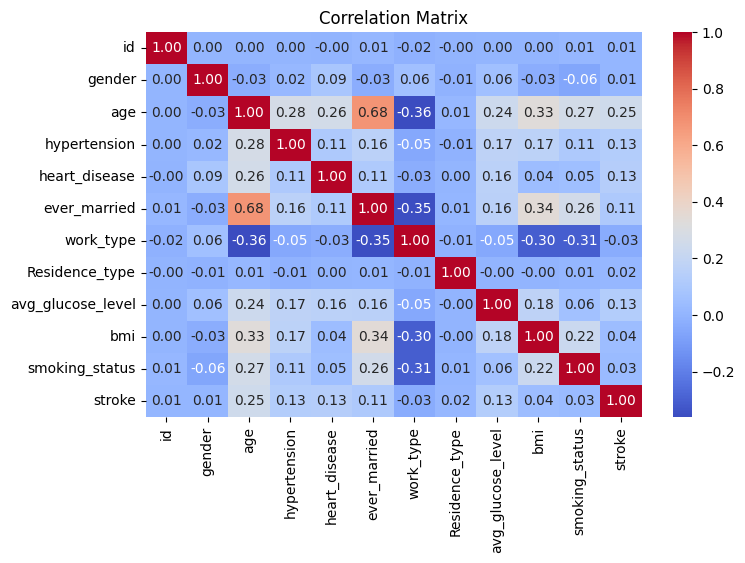


Correlation Matrix:
                         id    gender       age  hypertension  heart_disease  \
id                 1.000000  0.002511  0.003538      0.003550      -0.001296   
gender             0.002511  1.000000 -0.028202      0.020994       0.085447   
age                0.003538 -0.028202  1.000000      0.276398       0.263796   
hypertension       0.003550  0.020994  0.276398      1.000000       0.108306   
heart_disease     -0.001296  0.085447  0.263796      0.108306       1.000000   
ever_married       0.013690 -0.031005  0.679125      0.164243       0.114644   
work_type         -0.015757  0.056422 -0.361642     -0.051761      -0.028023   
Residence_type    -0.001403 -0.006738  0.014180     -0.007913       0.003092   
avg_glucose_level  0.001092  0.055180  0.238171      0.174474       0.161857   
bmi                0.003084 -0.026678  0.333398      0.167811       0.041357   
smoking_status     0.014074 -0.062581  0.265199      0.111038       0.048460   
stroke             

In [ ]:
df = check_duplicate_rows_with_visualization(df)

In [ ]:
df=remove_useless_columns_using_correlation(df)
print(df)

Detected 'id' column, removing it. Reason: The column is detected as not contributing significantly to other features.
Columns dropped: id
      gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Pri

*italicized text*# New Section